# Small Word World

In [54]:
# Python dependencies
import warnings
import random

# 3rd Party dependencies
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator

In [55]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

## Intentionally Limited Vocabulary

We'll train a model with a text that's limited to this vocabulary.

In [56]:
use_verbs = True

adjectives = ["serene", "vibrant", "silent", "endless"]
nouns = ["river", "dream", "mountain", "idea"]
verbs = ["flows", "grows", "whispers", "shines"]

We generate random sentences with those words by randomly concatenating a noun, an adjective and a verb.

In [57]:
sentence_count = 100

if use_verbs:
    twelve_word_world = [
        random.choice(adjectives) + " " + random.choice(nouns) + " " + random.choice(verbs)
        for _ in range(sentence_count)
    ]
else:
    twelve_word_world = [
        random.choice(adjectives) + " " + random.choice(nouns)
        for _ in range(sentence_count)
    ]

In [61]:
from scratch.tokenizers.preprocessor import Preprocessor
from scratch.tokenizers.simple_tokenizer import SimpleTokenizer

def strings_to_text(strings: list[str]):
    return " <|endoftext|> ".join(strings) + " <|endoftext|>"

text_data = strings_to_text(twelve_word_world)

text_data

'silent idea <|endoftext|> endless river <|endoftext|> vibrant dream <|endoftext|> silent mountain <|endoftext|> vibrant river <|endoftext|> silent idea <|endoftext|> silent idea <|endoftext|> vibrant dream <|endoftext|> vibrant mountain <|endoftext|> endless idea <|endoftext|> vibrant idea <|endoftext|> endless idea <|endoftext|> vibrant river <|endoftext|> endless idea <|endoftext|> serene river <|endoftext|> vibrant idea <|endoftext|> endless river <|endoftext|> vibrant river <|endoftext|> silent dream <|endoftext|> serene mountain <|endoftext|> serene river <|endoftext|> endless idea <|endoftext|> silent idea <|endoftext|> vibrant river <|endoftext|> vibrant river <|endoftext|> endless river <|endoftext|> silent idea <|endoftext|> silent idea <|endoftext|> vibrant idea <|endoftext|> vibrant idea <|endoftext|> silent river <|endoftext|> vibrant idea <|endoftext|> vibrant idea <|endoftext|> vibrant mountain <|endoftext|> vibrant river <|endoftext|> vibrant river <|endoftext|> silent 

In [62]:
preprocessor = Preprocessor()
source = preprocessor.preprocess(text_data)
tokenizer = SimpleTokenizer(source)

print("Vocabulary size", len(tokenizer.str_to_int))
print("Sentences", len(twelve_word_world))
print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Vocabulary size 10
Sentences 100
Total characters 2767
Total tokens 300


In [63]:
tokenizer.int_to_str

{0: '<|endoftext|>',
 1: '<|unk|>',
 2: 'dream',
 3: 'endless',
 4: 'idea',
 5: 'mountain',
 6: 'river',
 7: 'serene',
 8: 'silent',
 9: 'vibrant'}

## Micro GPT Model

We instantiate a very tiny model in order to make it quite easy to debug.

In [64]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig(
    vocab_size = len(tokenizer.str_to_int),
    context_length = 5,
    embedding_dimension = 3,
    head_count = 1,
    layer_count = 1,
    drop_rate = 0,
    qkv_bias = False
)

model = GptModel(config)

model.eval()

GptModel(
  (token_embeddings): Embedding(10, 3)
  (positional_embeddings): Embedding(5, 3)
  (dropout_embeddings): Dropout(p=0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (normalizer): SoftmaxNormalizer()
        (W_query): Linear(in_features=3, out_features=3, bias=False)
        (W_key): Linear(in_features=3, out_features=3, bias=False)
        (W_value): Linear(in_features=3, out_features=3, bias=False)
        (out_proj): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=3, out_features=12, bias=True)
          (1): Gelu()
          (2): Linear(in_features=12, out_features=3, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0, inplace=False)
    )
  )
  (final_normal

Now that our model has just been created with random weights, we'll store its embedding weights so that we can later compare the initial values with the trained ones.

In [66]:
initial_embeddings = model.token_embeddings.weight.clone().to("cpu")

### Count the Model Parameters

In [65]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

219

### Preparing the Training and Validation Datasets

In [67]:
train_ratio = 0.9
split_idx = int(train_ratio * len(twelve_word_world))

train_data = strings_to_text(twelve_word_world[:split_idx])
validation_data = strings_to_text(twelve_word_world[split_idx:])

print(validation_data)

endless dream <|endoftext|> endless river <|endoftext|> endless dream <|endoftext|> serene dream <|endoftext|> silent dream <|endoftext|> vibrant idea <|endoftext|> serene river <|endoftext|> endless idea <|endoftext|> serene mountain <|endoftext|> endless mountain <|endoftext|>


In [68]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
    tokenizer=tokenizer,
)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
    tokenizer=tokenizer,
)

### Checking the Losses before Training

In [69]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 2.3237666625242968
Validation loss 2.327567974726359


## Train

### Prepare a Trainer

In [70]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator
from scratch.training.simple_trainer import SimpleTrainer

generator = ProbabilisticTextGenerator(
    model,
    config.context_length,
    temperature = 1.1,
    top_k = 4,
    eos_id = tokenizer.encode("<|endoftext|>")[0]
)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    tokenizer = tokenizer,
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr = 0.05,
        weight_decay = 0.1
    ),
    generator = generator
)

### Run the Training Loop

In [71]:
num_epochs = 10

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 10**10,
    start_context = "silent")


- Step 0
- Train loss 2.22976762514848
- Evaluation loss 2.3301453590393066
- Generated: silent river

- Step 50
- Train loss 0.9768690123007848
- Evaluation loss 1.1264520088831584
- Generated: silent dream
- Generated: silent idea

- Step 100
- Train loss 0.9426325146968548
- Evaluation loss 1.0795299609502156
- Generated: silent mountain
- Generated: silent dream

- Step 150
- Train loss 0.9381915949858152
- Evaluation loss 1.0592822035153706
- Generated: silent river
- Generated: silent river

- Step 200
- Train loss 0.9215315672067496
- Evaluation loss 1.0473070939381917
- Generated: silent idea
- Generated: silent dream

- Step 250
- Train loss 0.9288286452109997
- Evaluation loss 1.0703104933102925
- Generated: silent river

Training finished


In [85]:
input_text = 'endless'

idx = tokenizer.text_to_tokens(input_text).to(trainer.device)
generated = generator.generate(idx)
tokenizer.tokens_to_text(generated)

'endless idea'

### Checking the Losses during Training

<Figure size 1000x600 with 0 Axes>

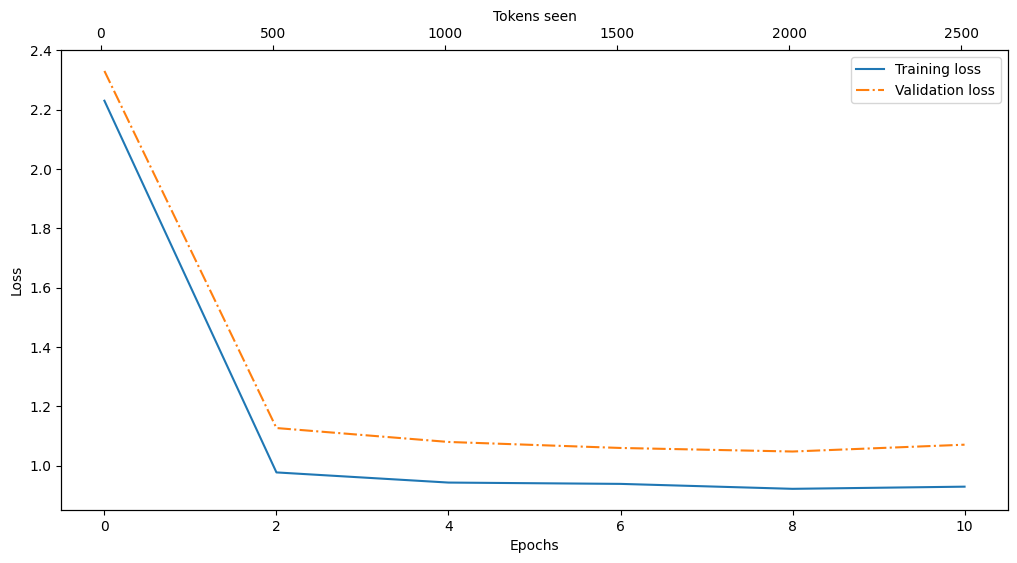

In [86]:
def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    plt.clf()
    fig, ax1 = plt.subplots()

    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    plt.show()

%matplotlib inline

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

## Checking the Embedding Changes

In [87]:
trained_embeddings = model.token_embeddings.weight.clone().to("cpu")

In [88]:
def classify(word: str) -> int:
    if word in adjectives:
        return 0
    if word in nouns:
        return 1
    if word in verbs:
        return 2
    return 3

classes = {
    0: "Adjective",
    1: "Noun",
    2: "Verb",
    3: "Keyword",
}

classification = {token: classify(word) for token, word in tokenizer.int_to_str.items()}
classification

{0: 3, 1: 3, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0}

In [89]:
colors = {
    0: "tab:blue",
    1: "tab:green",
    2: "tab:red",
    3: "tab:purple",
}

<Figure size 640x480 with 0 Axes>

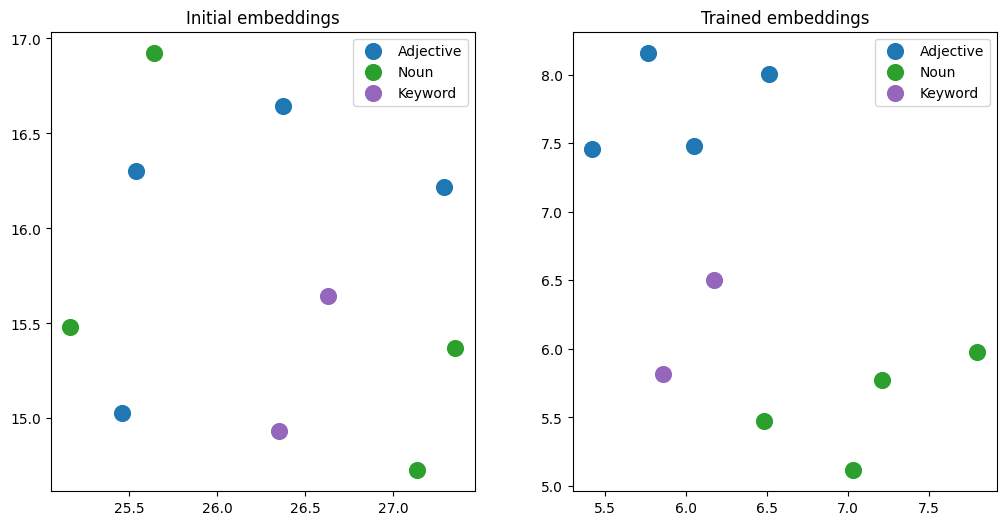

In [90]:
def scat_umap_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    reducer = umap.UMAP(n_components = 2)
    reduced_embeddings = reducer.fit_transform(embeddings.tolist())
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        selection = np.where(groups == group)
        ax.scatter(
            reduced_embeddings[selection][:, 0],
            reduced_embeddings[selection][:, 1],
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_umap_embedding_changes():
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_umap_embeddings(ax1, initial_embeddings, "Initial embeddings")
    scat_umap_embeddings(ax2, trained_embeddings, "Trained embeddings")
    
    plt.show()

%matplotlib inline

plot_umap_embedding_changes()

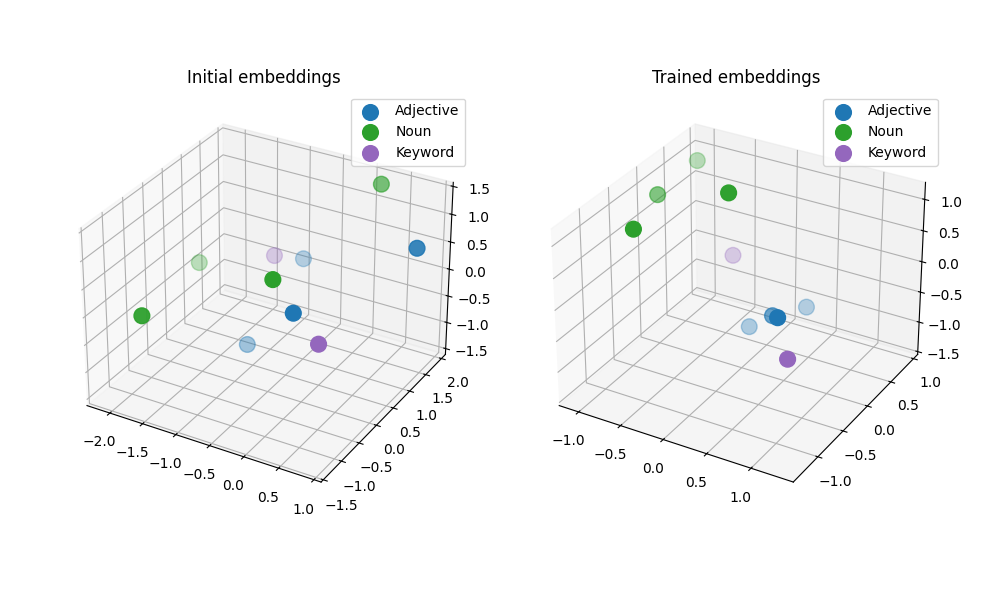

In [91]:
%matplotlib widget

def scat_3d_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        index = np.where(groups == group)
        ax.scatter(
            embeddings[index][:, 0].detach().numpy(),
            embeddings[index][:, 1].detach().numpy(),
            embeddings[index][:, 2].detach().numpy(),
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_3d_embedding_differences():
    plt.clf()
    fig = plt.figure(1, 2)
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_3d_embeddings(ax1, initial_embeddings, "Initial embeddings")
    scat_3d_embeddings(ax2, trained_embeddings, "Trained embeddings")
    
    plt.show()

if initial_embeddings.shape[1] == 3:
    plot_3d_embedding_differences()